In [3]:
#import pyodbc
import pandas as pd
import numpy as np
import os
import glob
#%run -i qadconnect.py
import datetime as dt
#%run -i helper_20150211.py
%pylab inline

def get_im_sub(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

#receives a list of dates and outputs a list of 3rd fridays exept of the 1st month (double check behavior if dates in 1st month not complete)
def get_3rd_fridays(date_list):
    dates = pd.DatetimeIndex(date_list)
    isfriday=(dates.weekday==4)
    ismonthstart=(dates.day[0:len(dates)-1]>dates.day[1:len(dates)])
    dates1=dates[1:len(dates)]
    monthstarts=dates1[ismonthstart]
    fridays=dates[isfriday]
    fridaystokeep=fridays>=monthstarts[0]
    fridays=fridays[fridaystokeep]

    thirdfriday=[]
    for i in range(0,len(monthstarts)-1):
        isfridaysofthemonth=(fridays>=monthstarts[i]) & (fridays<monthstarts[i+1])
        fridaysofthemonth=fridays[isfridaysofthemonth]
        if len(fridaysofthemonth)>=2:
            thirdfriday.append(fridaysofthemonth[2])
    return thirdfriday

def rollCorr(a,b,window):
    rollCorr=np.zeros((len(a)))
    window=window-1
    for i in range(window,len(a)):
        rollCorr[i]=myCorr(a[i-window:i+1],b[i-window:i+1])
    return rollCorr

def myCorr(a,b):
    l=len(a)
    cov=sum(a*b)/l-sum(a)/l*sum(b)/l  
    vara=sum(a*a)/l-sum(a)/l*sum(a)/l   
    varb=sum(b*b)/l-sum(b)/l*sum(b)/l
    return float(cov/(np.sqrt(vara)*np.sqrt(varb)))

Populating the interactive namespace from numpy and matplotlib


,dt,ctb_pr,ctb_tr
58,2014-11-24,0.001113,0.001113
59,2014-12-22,0.001168,0.001168
60,2015-01-19,0.001415,0.001415
61,2015-02-23,0.001536,0.001538
62,2015-03-23,0.001492,0.001495


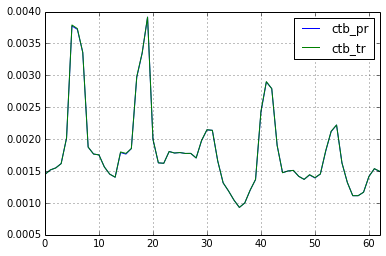

In [4]:
#getting cost to borrow
DAX='DE0008467440', 'DE0008469008'
loc='M:/Reviews/Costtoborrow/Output/'
loc2='G:/stoxx/STOXX/Product Development & Research/Projects/1757 DAX Lev and Short - x9 x10/05 Data/02 History/'

df2 = pd.DataFrame(columns=['dt', 'isin', 'ctb'])
yrs= 2010, 2011, 2012, 2013, 2014, 2015
for y in yrs:
    mypath=loc+str(y)+"/"
    for fld in get_im_sub(mypath):
        for filename in glob.glob(mypath+fld+'/*.csv'):
            df1 = pd.read_csv(filename,sep=';',index_col=None)
            df1.columns=['dt','isin','ctb']
            df1=pd.concat([df1[df1['isin']==DAX[0]],df1[df1['isin']==DAX[1]]])
            df2=df2.append(df1)
            
df2['dt']=pd.to_datetime(df2.dt, format="%Y%m%d", dayfirst=True)
df2['ctb']=df2['ctb'].astype(float)
df2['ctb']=df2['ctb']/100

df2=df2.append(pd.read_excel(loc2+'ctb_missing.xlsx', sheetname='ctb_missing')) #append the ctb calculated separately
df2=df2.sort(['isin', 'dt'], ascending=[True, True])

dfp=df2[df2['isin']==DAX[0]]
dfr=df2[df2['isin']==DAX[1]]
dfctb=pd.merge(dfp,dfr,how='outer', on='dt')
dfctb = dfctb.rename(columns={'ctb_x': 'ctb_pr', 'ctb_y': 'ctb_tr'})
del dfctb['isin_x']
del dfctb['isin_y']
#dfres.index=dfres.dt
#del dfres['dt']
#dfctb.to_excel(loc2+'CTB_'+str(dt.date.today())+'.xlsx')
dfctb.plot()
dfctb.tail()

In [5]:
df1

,dt,isin,ctb
28,20150323,DE0008467440,0.1492165
27,20150323,DE0008469008,0.1494947


In [2]:
#getting daily index data
loc3='G:/stoxx/STOXX/Product Development & Research/Projects/1757 DAX Lev and Short - x9 x10/05 Data/02 History/Cost of Borrow- Index close DAX PR TR_1.xlsx'
dfi=pd.read_excel(loc3, sheetname='idx')
dfi=pd.merge(dfi[dfi['MR_ISIN']==DAX[0]],dfi[dfi['MR_ISIN']==DAX[1]],how='outer', on='FACT_DATE')
dfi = dfi.rename(columns={'FACT_DATE':'dt', 'INDEX_CLOSE_x': 'idx_pr', 'INDEX_CLOSE_y': 'idx_tr'})
del dfi['MR_ISIN_x']
del dfi['MR_ISIN_y']
dfi=dfi.sort(['dt'], ascending=True)

#rebasing here
#dfi['idx_pr']=(dfi['idx_pr']/dfi.iloc[0,1])*100
#dfi['idx_tr']=(dfi['idx_tr']/dfi.iloc[0,2])*100
#dfi.index=dfi.FACT_DATE
#dfi.fillna(method='pad', inplace=True)
dfi.plot()
dfi.tail()

NameError: name 'DAX' is not defined

In [4]:
isequal=dfi.iloc[0:len(dfi)-1,1]==dfi.iloc[1:len(dfi),1] #cuantos valores del dax son iguales
print(sum(isequal))
v=isequal*range(0,len(dfi)-1,1)
v1=v[v>0]
dfi.loc[v1,['dt','idx_pr']]
t=range(0,len(dfi)-1,1)
#isequal

0


,dt,EONIA,EUR012M,EUSWE1
1371,2015-03-30,-0.00050,0.00198,-0.00113
1372,2015-03-31,-0.00050,0.00198,-0.00112
1373,2015-04-01,-0.00070,0.00198,-0.00112
1374,2015-04-02,-0.00070,0.00198,-0.00112
1375,2015-04-07,-0.00079,0.00198,-0.00112


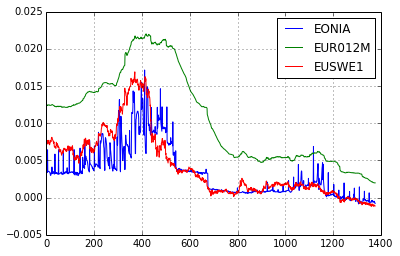

In [5]:
#getting eonia, euribor, eur eonia swap rates

dfrate1=pd.read_excel(loc3, sheetname='EONIA')
dfrate2=pd.read_excel(loc3, sheetname='EURIBOR')
dfrate3=pd.read_excel(loc3, sheetname='EUREONIASW')
dfrates=pd.merge(pd.merge(dfrate1, dfrate2, on='Date', how='outer'), dfrate3, on='Date', how='outer').sort('Date', ascending=True)
#dfrates.iloc[:,1:]=dfrates.iloc[:,1:].astype(float)
dfrates = dfrates.rename(columns={'Date':'dt'})
dfrates.reset_index(inplace=True,drop=True)
dfrates.fillna(method='pad', inplace=True) #rather check to have the full data to the same date
dfrates.iloc[:,1:]=dfrates.iloc[:,1:]/100 #divide all the rates by 100
dfrates.plot()
dfrates.tail()

In [6]:
#merge all data
dfall=pd.merge(pd.merge(dfi,dfctb, on='dt', how='outer'),dfrates,on='dt', how='outer').sort('dt', ascending=True)

#temporary take olny from first ctb available until index values are there ----- to change once all data availabe
dfall=dfall[dfall['dt'] > dt.date(2009,11,1)] #change from date to (2009,12,30)
#dfall=dfall[dfall['dt'] < dt.date(2015,2,6)] #comment out all 

#rebasing on the 30 Dec 2009
b_val_pr=float(dfall[dfall['dt']==dt.date(2009,12,30)]['idx_pr']) #base values
b_val_tr=float(dfall[dfall['dt']==dt.date(2009,12,30)]['idx_tr'])

#dfall['idx_pr']=(dfall['idx_pr']/b_val_pr)*100
#dfall['idx_tr']=(dfall['idx_tr']/b_val_tr)*100

dfall.fillna(method='pad', inplace=True)
dfall.reset_index(inplace=True,  drop=True)

dfall=dfall[dfall.index!=24] #getting rid of the 1 Jan

#dfall.to_excel(loc2+'shrtlev_'+str(dt.date.today())+'.xlsx')
dfall.tail(30)
#dfall.iloc[:,1:3].plot()

,dt,idx_pr,idx_tr,ctb_pr,ctb_tr,EONIA,EUR012M,EUSWE1
1346,2015-02-23,5708.51,11130.92,0.001536,0.001538,-0.00044,0.00246,-0.000840
1347,2015-02-24,5746.94,11205.74,0.001536,0.001538,-0.00048,0.00245,-0.000800
1348,2015-02-25,5749.19,11210.27,0.001536,0.001538,-0.00046,0.00241,-0.000940
1349,2015-02-26,5809.31,11327.19,0.001536,0.001538,-0.00062,0.00238,-0.000870
1350,2015-02-27,5847.48,11401.66,0.001536,0.001538,0.00064,0.00233,-0.001040
1351,2015-03-02,5852.15,11410.36,0.001536,0.001538,-0.00055,0.00230,-0.000810
1352,2015-03-03,5785.40,11280.36,0.001536,0.001538,-0.00063,0.00228,-0.000800
1353,2015-03-04,5841.91,11390.38,0.001536,0.001538,-0.00060,0.00227,-0.000825
1354,2015-03-05,5900.13,11504.01,0.001536,0.001538,-0.00060,0.00226,-0.000800
1355,2015-03-06,5924.29,11550.97,0.001536,0.001538,-0.00064,0.00225,-0.000930


In [7]:
#calculate liquidity spreads
third_fridays=get_3rd_fridays(dfall['dt'])
df3f=pd.DataFrame({'dt': third_fridays, 'is3rdfr': third_fridays})
dfall= pd.merge(dfall, df3f, how='left', on=['dt'])

liq_spr=0
df_liq_spr=pd.DataFrame(columns=['eff_index','liq_spr'])

ixf=dfall.index[dfall.is3rdfr.notnull()] #list of indices when the is3rdfr not null, indices of the 3rd fridays
del dfall['is3rdfr']
for i in ixf:
    liq_spr=mean(dfall.iloc[i-5:i,6]-dfall.iloc[i-5:i,7]) #mean of the difference of previous 5 values
    df_liq_spr.loc[len(df_liq_spr)+1]=[i+1,liq_spr] #inserting index+1 to refer to the effective date
df_liq_spr.index=df_liq_spr['eff_index']
del df_liq_spr['eff_index']
df_liq_spr.index.name= None

dfall=pd.merge(dfall, df_liq_spr, how='left', left_index=True, right_index=True)
dfall['liq_spr'].fillna(method='pad', inplace=True)
dfall.tail(10)
dfall.to_excel(loc2+'shrtlev_parameters_'+str(dt.date.today())+'.xlsx')

,dt,idx_9_pr,idx_9_tr,idx_10_pr,idx_10_tr,idx_-9_pr,idx_-9_tr,idx_-10_pr,idx_-10_tr
0,2009-12-31,1000,1000,1000,1000,10000,10000,10000,10000
1,2010-01-04,1136.528,1136.536,1151.688,1151.696,8629.624,8629.552,8477.318,8477.237
2,2010-01-05,1108.534,1108.525,1120.165,1120.155,8841.08,8841.124,8708.114,8708.16
3,2010-01-06,1112.406,1112.409,1124.51,1124.513,8809.06,8809.011,8673.063,8673.007
4,2010-01-07,1087.377,1087.363,1096.395,1096.379,9006.146,9006.232,8888.657,8888.749


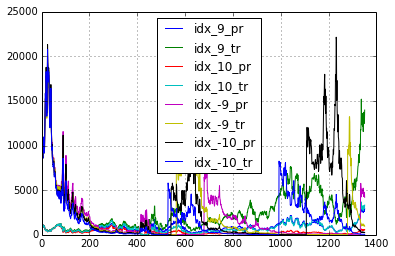

In [8]:
#calculate all indices
vs=['pr','tr']
lev=[9, 10, -9,-10]
b_dt=dt.date(2009,12,31)

df3 = pd.DataFrame(columns=['dt'])
df3['dt']=dfall[dfall['dt']>=b_dt]['dt']
df3.reset_index(inplace=True, drop=True)

for l in lev:
    if l<0:
        base_val=10000
        lev_fmult=1000
    else:
        base_val=1000
        lev_fmult=100
    for v in vs:
           
        df2 = pd.DataFrame(columns=['dt', 'dax', 'eonia', 'ctb','liq_spr','idx'])
        df2[['dt','dax','eonia','ctb','liq_spr']]= dfall[dfall['dt']>=b_dt][['dt','idx_'+v, 'EONIA','ctb_'+v,'liq_spr']]
        df2.reset_index(inplace=True, drop=True)
        df2.iloc[0,5]=base_val

        d_ct=1
        for i in range(1,len(df2)):
            lev_term = l * ((df2.iloc[i,1] / df2.iloc[i-1,1])-1)
            if l<0: #short indices
                fin_term = (((1-l) * df2.iloc[i,2]) + (l*df2.iloc[i,3]))/360 * (df2.iloc[i,0]-df2.iloc[i-1,0]).days
            else: #leveraged
                fin_term = ((1-l) * (df2.iloc[i,2] + df2.iloc[i,4]))/360 * (df2.iloc[i,0]-df2.iloc[i-1,0]).days
            df2.iloc[i,5] = df2.iloc[i-1,5] * (1 + lev_term + fin_term)
            if i>10:
                d_ct=d_ct-1
                if df2.iloc[i-11,5]<10 and d_ct<1:
                    df2.iloc[i,5]=df2.iloc[i,5]*lev_fmult
                    d_ct=11

            df3['idx_'+str(l)+'_'+v]=df2['idx']
            
df3['dt']=pd.to_datetime(df3.dt, format="%Y%m%d", dayfirst=True)
#df3.iloc[:,1:]=(df3.iloc[:,1:]/df3.iloc[0,1:])*100 #rebase all indices for export

#export results with isins
loc_vcs='G:/stoxx/STOXX/Product Development & Research/Projects/1757 DAX Lev and Short - x9 x10/05 Data/01 WFT/isins.csv'
dfisins=pd.read_csv(loc_vcs,sep=';',index_col=None)
dfresults=df3
for i in range (0, len(dfisins)):
    dfresults=dfresults.rename(columns={dfisins.iloc[i,4]:dfisins.iloc[i,1]})
dfresults.index=dfresults['dt']
dfresults.index.name=None
del dfresults['dt']

#dfresults=np.round(dfresults.convert_objects(convert_numeric=True),decimals=2) #round to 2 decimals
dfresults.to_excel(loc2+'shrtlev_histories_'+str(dt.date.today())+'.xlsx')

df3.plot()
df3.head()

,dt,idx_9_pr,idx_9_tr,idx_10_pr,idx_10_tr,idx_-9_pr,idx_-9_tr,idx_-10_pr,idx_-10_tr
0,2009-12-31,100,100,100,100,100,100,100,100
1,2010-01-04,113.6528,113.6536,115.1688,115.1696,86.29624,86.29552,84.77318,84.77237
2,2010-01-05,110.8534,110.8525,112.0165,112.0155,88.4108,88.41124,87.08114,87.0816
3,2010-01-06,111.2406,111.2409,112.451,112.4513,88.0906,88.09011,86.73063,86.73007
4,2010-01-07,108.7377,108.7363,109.6395,109.6379,90.06146,90.06232,88.88657,88.88749


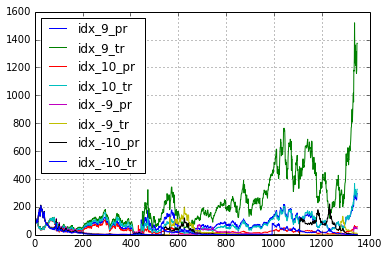

In [9]:
dftest=df3
dftest.iloc[:,1:]=(dftest.iloc[:,1:]/dftest.iloc[0,1:])*100 #rebase all indices
dftest.plot()
#dftest.iloc[430:440,[1,3]].plot()
#dftest.iloc[430:440,[1,3]]
dftest.head()

,dax,eonia,ctb,liq_spr,idx
2012-05-02,103.708636,0.00343,0.001705,0.010154,1598.58
2012-05-03,103.459748,0.00343,0.001705,0.010154,1571.363
2012-05-04,101.064644,0.00343,0.001705,0.010154,1316.367
2012-05-07,101.115144,0.00348,0.001705,0.010154,1320.074
2012-05-08,99.201170,0.00346,0.001705,0.010154,1144.864


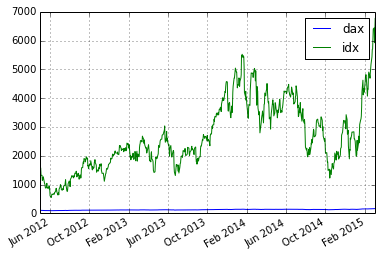

In [139]:
#calculate individual indices
#['pr','tr']
#[9, 10, -9,-10]

b_dt=dt.date(2012,5,2)
#b_dt=dt.date(2009,12,31)
v='pr'
l=7

if l<0:
    base_val=10000
    lev_fmult=1000
else:
    base_val=1000
    lev_fmult=100

base_val=1598.58
           
dfindex = pd.DataFrame(columns=['dt', 'dax', 'eonia', 'ctb','liq_spr','idx'])
dfindex[['dt','dax','eonia','ctb','liq_spr']]= dfall[dfall['dt']>=b_dt][['dt','idx_'+v, 'EONIA','ctb_'+v,'liq_spr']]
dfindex.reset_index(inplace=True, drop=True)
dfindex.iloc[0,5]=base_val
len(dfindex)
d_ct=1
for i in range(1,len(dfindex)):
    lev_term = l * ((dfindex.iloc[i,1] / dfindex.iloc[i-1,1])-1)
    #print(lev_term)
    if l<0: #short indices
        fin_term = (((1-l) * dfindex.iloc[i,2]) + (l*dfindex.iloc[i,3]))/360 * (dfindex.iloc[i,0]-dfindex.iloc[i-1,0]).days
    else: #leveraged
        fin_term = ((1-l) * (dfindex.iloc[i,2] + dfindex.iloc[i,4]))/360 * (dfindex.iloc[i,0]-dfindex.iloc[i-1,0]).days
        #print((df2.iloc[i,0]-df2.iloc[i-1,0]).days)
    dfindex.iloc[i,5] = dfindex.iloc[i-1,5] * (1 + lev_term + fin_term)
    if i>9:
        d_ct=d_ct-1
        if dfindex.iloc[i-11,5]<10 and d_ct<1:
            dfindex.iloc[i,5]=dfindex.iloc[i,5]*lev_fmult
            d_ct=11

    #print(dfindex.iloc[i-1,5])
    #print(str(lev_term)+' / '+str(fin_term))

#dfindex.iloc[:,5]=(dfindex.iloc[:,5]/dfindex.iloc[0,5])*100 #rebase the idx to compare with dax in the looped df
dfindex.index=dfindex.dt
dfindex.index.name= None
del dfindex['dt']

dfindex.iloc[:,[0,4]].plot()
#dfindex.iloc[:,[1,5]].plot()
dfindex.head()

,dax_6_pr,dax_6_tr,dax_7_pr,dax_7_tr,dax_8_pr,dax_8_tr,dax_-6_pr,dax_-6_tr,dax_-7_pr,dax_-7_tr,dax_-8_pr,dax_-8_tr
2012-05-02,1561.8,1745.85,1598.58,1821.12,1611.34,1870.98,3857.57,3458.62,3130.13,2756.06,2502.44,2163.84


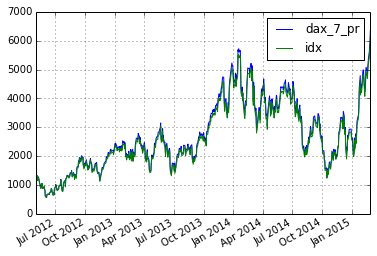

In [140]:
#compare with current indices (factors 6, 7 and 8)
lev8='DE000A1EXY77', 'DE000A1EXY28', 'DE000A1EXY85', 'DE000A1EXY36', 'DE000A1EXY93', 'DE000A1EXY44', 'DE000A1EXZH2', 'DE000A1EXZC3', 'DE000A1EXZJ8', 'DE000A1EXZD1', 'DE000A1EXZK6', 'DE000A1EXZE9'
lev8n='dax_6_pr', 'dax_6_tr', 'dax_7_pr', 'dax_7_tr', 'dax_8_pr', 'dax_8_tr', 'dax_-6_pr', 'dax_-6_tr', 'dax_-7_pr', 'dax_-7_tr', 'dax_-8_pr', 'dax_-8_tr'

dff=pd.read_excel(loc2+'icos data/Hist_Data.xls', sheetname='Sheet 1')
del dff['INSTRUMENT_NAME']
dff.head(1)

dff8=dff[dff['ISIN']==lev8[0]]
dff8=dff8.rename(columns={'INDEX_VALUE':lev8n[0]})
del dff8['ISIN']
for i in range(1,len(lev8)):
    dff8=pd.merge(dff8, dff[dff['ISIN']==lev8[i]], how='outer', on='FACT_DATE')
    dff8=dff8.rename(columns={'INDEX_VALUE':lev8n[i]})
    del dff8['ISIN']
dff8.index=dff8.FACT_DATE
dff8.index.name= None
del dff8['FACT_DATE']

dfcompare=pd.merge(dff8, dfindex, how='left', left_index=True, right_index=True).iloc[:,[2,16]]
dfcompare.plot()
dff8.head(1)
#len(dff8)
#dfcompare.to_excel(loc2+'compare_'+str(dt.date.today())+'.xlsx')

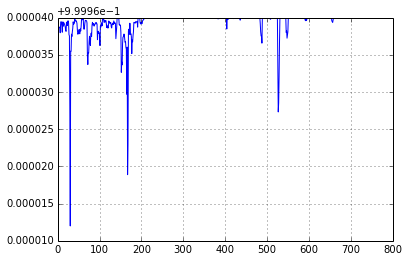

In [141]:
#calculating returns and rolling correlation
returns=array(dfcompare.iloc[1:len(dfcompare),[0,1]])/array(dfcompare.iloc[0:len(dfcompare)-1,[0,1]])
dfcorr=pd.DataFrame({'dax': returns[:,0], 
                     'idx': returns[:,1], 
                     'rolCorr': rollCorr(returns[:,0],returns[:,1],5)}) #5 periods

dfcorr.rolCorr[4:].plot()
#dfcorr.to_excel(loc2+'correlation_'+str(dt.date.today())+'.xlsx')

In [132]:
dfcheck2=dfcompare
#dfcheck2.iloc[:,:]
dfcheck2.tail()

,dax_7_pr,idx
2015-02-20,5355.47,5169.769
2015-02-23,5627.29,5432.148
2015-02-24,5892.20,5687.868
2015-02-25,5908.07,5703.18
2015-02-26,6340.26,6120.373


In [143]:
dfcheck1=dfcompare
dfcheck1.tail()

,dax_7_pr,idx
2015-02-20,5355.47,5171.328
2015-02-23,5627.29,5433.789
2015-02-24,5892.20,5689.589
2015-02-25,5908.07,5704.904
2015-02-26,6340.26,6122.238


In [144]:
#looking for the effective dt and calculated LS
liqs=array(dfall.iloc[:,[0,8]].fillna(0))
effect=liqs[1:len(liqs),1]!=liqs[0:len(liqs)-1,1]
effdts=liqs[effect]
dfLS=pd.DataFrame(effdts)